In [1]:
import time
import warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# 경고 메시지 무시
warnings.filterwarnings(action='ignore')

# 분석 수행 및 결과 저장 클래스 선언

In [2]:
class CrackAnalyzer:
    
    def __init__(self, modeldir):
        self.modeldir = modeldir
        self.elapsed_time = 0
        self.predict_list = []
        
    def analysis(self, input_list):
        
        with tf.Session() as sess:
            print("START : " + self.modeldir)
            
            # 모델 로딩
            tf.saved_model.loader.load(sess, ["serve"], self.modeldir)
            
            graph = tf.get_default_graph()
            
            x = graph.get_tensor_by_name("in:0")
            out = graph.get_tensor_by_name("pred:0")

            print('input_list : {}'.format(input_list.shape))
            print('out : {}'.format(out))
            
            # 모델 분석 수행
            start_time = time.time()
            _out = sess.run(out, feed_dict={x:input_list})
            end_time = time.time()
            
            self.elapsed_time = end_time - start_time            
            self.predict_list = _out
                
            print("END : " + self.modeldir)
            
            return self.predict_list

# 분석할 데이터 로딩

In [3]:
# 학습 데이터 파일명
train_list_file = "./images.npy"
# 라벨 데이터 파일명
label_list_file = "./masks.npy"

print("load train data: ", train_list_file) 
train_list = np.load(train_list_file, allow_pickle=True)
print("load complete")

print("load train label data: ", label_list_file)
label_list = np.load(label_list_file, allow_pickle=True)
print("load complete")

print(train_list.shape)
print(label_list.shape)

load train data:  ./images.npy
load complete
load train label data:  ./masks.npy
load complete
(11298, 448, 448, 1)
(11298, 448, 448, 1)


In [4]:
# # 라벨 생성
# n1 = np.ones((train_list.shape[0],1))
# n2 = np.zeros((train_list.shape[0],1))
# label_list = np.hstack([n1,n2])

# n1 = np.ones((normal_list.shape[0],1))
# n2 = np.zeros((normal_list.shape[0],1))
# label_list = np.vstack([label_list,np.hstack([n2,n1])])

# # 데이터 합치기
# train_list = np.vstack([train_list,normal_list])
# print(train_list.shape)
# print(label_list.shape)

# 분석 데이터에서 분석 수행용 데이터 일부 추출

In [5]:
# 분석할 데이터 개수
analysis_count = 10
# 분석 데이터 중 최초 데이터 위치 
#base_index = np.random.randint(label_list.shape[0] - analysis_count)
base_index = 0

# 분석용 데이터와 라벨
analysis_x = train_list[base_index:base_index + analysis_count]
analysis_y = label_list[base_index:base_index + analysis_count]
print('analysis_x : {}'.format(analysis_x.shape))

analysis_x : (10, 448, 448, 1)


# 분석 모델 로딩 및 분석 수행

In [6]:
# 분석 모델 디렉토리명
modeldir = "/src/hyebin/model/UNET/CRACK-UNET-24"

analyzer = CrackAnalyzer(modeldir)
predict_list = analyzer.analysis(analysis_x)
print(predict_list.shape)

START : /src/hyebin/model/UNET/CRACK-UNET-24
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /src/hyebin/model/UNET/CRACK-UNET-24/variables/variables
input_list : (10, 448, 448, 1)
out : Tensor("pred:0", shape=(?, 448, 448, 1), dtype=float32)
END : /src/hyebin/model/UNET/CRACK-UNET-24
(10, 448, 448, 1)


In [7]:
pred_list = []
label_list = []

for i in range(analysis_count):
    # 예측값 
    pred = analyzer.predict_list[i]

    # 라벨값
    label = analysis_y[i]
    
    pred_list.append(pred)
    label_list.append(label)

# 분류성능평가지표 함수

In [8]:
def performance(threshold, label, pred):    
    
    # 예측값 이진화 
    _pred = np.where(pred < threshold, 0, 1)

    # 1. 정밀도(Precision)
    precision = precision_score(label,_pred)
    
    # 2. 재현율(Recall)
    recall = recall_score(label,_pred)
    
    # 3. 정확도(Accuracy)
    accuracy = accuracy_score(label,_pred)

    return precision, recall, accuracy

# 실행

In [9]:
if __name__ == '__main__':
    
    threshold = 0.5
    label = np.array(label_list)
    pred = np.array(pred_list)
    
    label = np.array(label_list)
    print('label: ', label.shape)
    pred = np.array(pred_list)
    print('pred: ', pred.shape)

    label = np.squeeze(label, axis=3)
    _label = label.reshape(-1)  # np.reshape(-1) : 1차원 배열 반환
    print('\nlabel: ', label.shape)

    pred = np.squeeze(pred, axis=3)
    _pred = pred.reshape(-1)
    print('pred: ', pred.shape ) 
    
    precision, recall, accuracy = performance(threshold, _label, _pred)
    
    print('\n================================')
    print('precision: %f'%precision)
    print('recall: %f'%recall)
    print('accuracy: %f'%accuracy)

label:  (10, 448, 448, 1)
pred:  (10, 448, 448, 1)

label:  (10, 448, 448)
pred:  (10, 448, 448)

precision: 0.219517
recall: 0.986862
accuracy: 0.947775


# 검증 (이미지)

In [10]:
def draw_plot_segmentation(image, pred, label):
    
    # pyplot의 현재 전체 이미지 크기를 백업 후 설정함
    tmp_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (15,7)  # 너비, 높이 (in)
    
    # 원본 데이터 출력
    plt.subplot(1,3,1)  # 한 번에 여러 그래프 출력
    plt.imshow(image.reshape([448,448]), cmap='gray')
    plt.axis('off')
    
    # 예측 데이터 출력
    plt.subplot(1,3,2)
    plt.imshow(pred.reshape([448,448]), cmap='gray')
    plt.axis('off')
    
    # 라벨 데이터 출력
    plt.subplot(1,3,3)
    plt.imshow(label.reshape([448,448]), cmap='gray')
    plt.axis('off')  

    plt.show()
    plt.close()
    
    # 백업된 pyplot 이미지 크기를 복원함
    plt.rcParams["figure.figsize"] = tmp_size

In [11]:
## --- 학습 결과 및 라벨 데이터 변환 함수 ---
def change_to_image(label, pred):
    
    rgb_pred = []
    rgb_label = []
    
    # 예측 데이터와 라벨 데이터의 0~1 값을 0~255 값으로 변환
    for x in range(448):
        for y in range(448):
            
            pred_row = [int(pred[x][y] * 255)]
            label_row = [int(label[x][y] * 255)]
            
            rgb_pred.append(pred_row)
            rgb_label.append(label_row)

    pred = np.array(rgb_pred).reshape([448,448,1])
    label = np.array(rgb_label).reshape([448,448,1])
    
    return pred, label

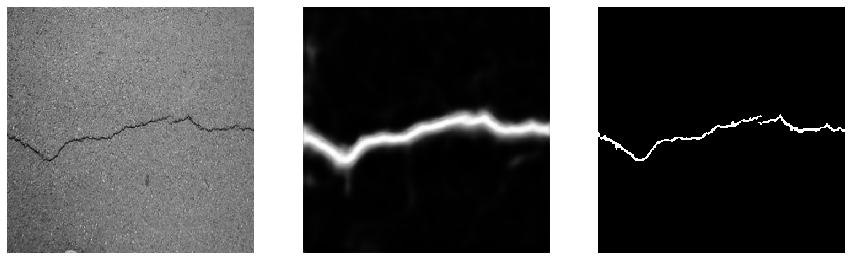

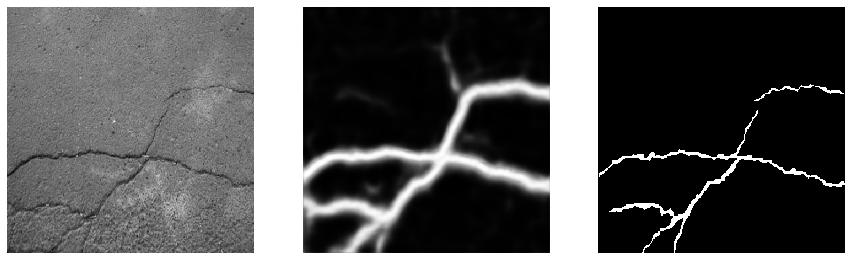

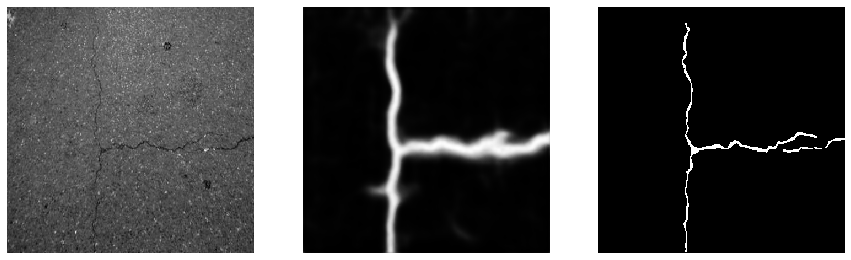

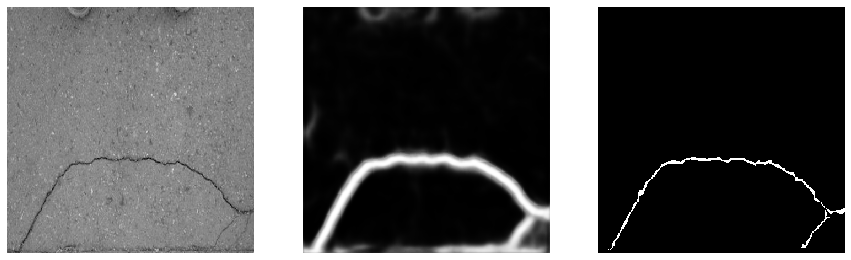

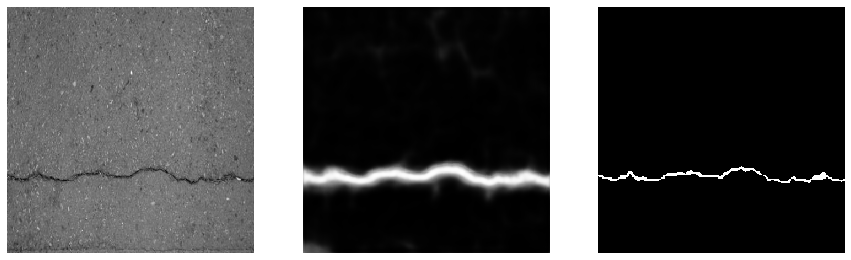

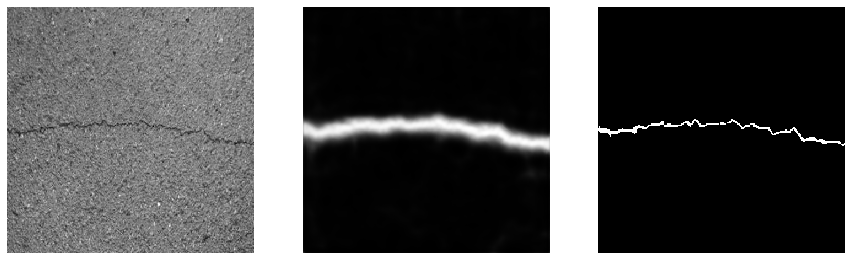

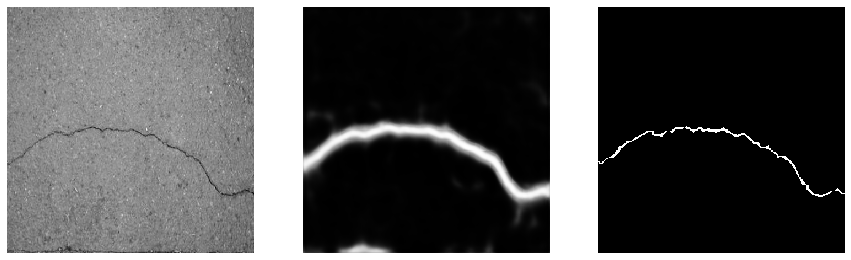

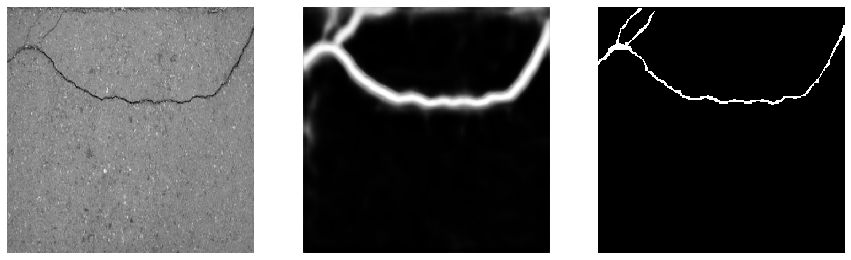

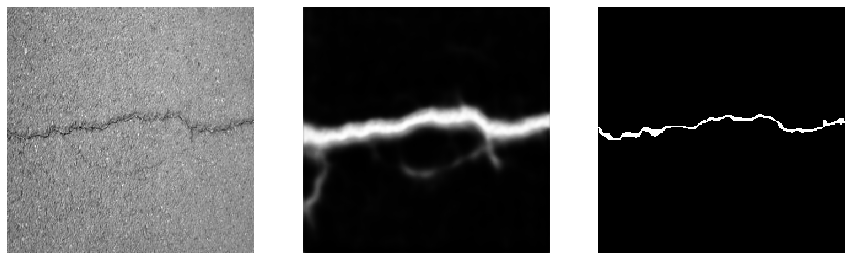

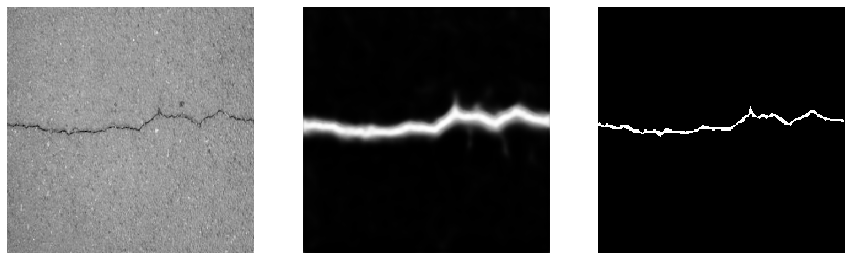

In [12]:
pred_data = []
label_data = []

# 예측 이미지와 라벨 이미지 화면 출력을 위한 변환 
for i in range(10):
    _pred, _label = change_to_image(analysis_y[i], predict_list[i])
    pred_data.append(_pred)
    label_data.append(_label)

# 분석 결과 이미지 출력
for i in range(10):
    draw_plot_segmentation(analysis_x[i], pred_data[i], label_data[i])

# 검증 (카운트)

In [13]:
# --- 분석 결과 출력 ---
# 정답 갯수
correct_count = 0
# 오답 갯수
incorrect_count = 0

print("=======================================")
print("index\tpredict\tlabel\tcorrect")
print("---------------------------------------")

for index in range(analysis_count):
    # 예측값 
    #predict = analyzer.predict_list[i]
    print('_pred:',_pred.shape)
    print(_pred)
    
    # 실제값
    #label = analysis_y[i]
    print('label:',label.shape)
    print(label)
    
    result = "0"
    
    # 정답일 경우, 정답 카운트 1 증가
    # 오답일 경우, 오답 카운트 1 증가 및 출력시 오른쪽에 X 표시
    
    if _pred[0]>_pred[1]:
        answer = 0
    else:
        answer = 1
    
    if answer == label:
        correct_count = correct_count + 1
    else:
        incorrect_count = incorrect_count + 1
        result = "X"
        message = "%d\t%s\t%s\t%s" %(base_index + index, predict, label, result)

        # 현재 이미지 분석 결과 출력 - 틀린것만
        print(message)

# 최종 결과 출력
print("=====================================")
print("running time:", analyzer.elapsed_time)
print("correct count:", correct_count, "\tcorrect percent:", (correct_count/analysis_count) * 100, "%")
print("incorrect count:", incorrect_count)

index	predict	label	correct
---------------------------------------
_pred: (448, 448, 1)
[[[29]
  [22]
  [10]
  ...
  [38]
  [64]
  [71]]

 [[21]
  [14]
  [ 6]
  ...
  [24]
  [41]
  [52]]

 [[12]
  [10]
  [ 3]
  ...
  [12]
  [26]
  [33]]

 ...

 [[18]
  [20]
  [ 7]
  ...
  [ 2]
  [ 9]
  [13]]

 [[32]
  [35]
  [14]
  ...
  [ 3]
  [12]
  [14]]

 [[41]
  [45]
  [18]
  ...
  [ 9]
  [20]
  [27]]]
label: (10, 448, 448)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()